In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = "D:\\Programmation\\Challenge ENS\\data\\"
outlier = 0.05
IQRoutliers = True

#Load x and y train data
input_test = pd.read_csv(path + "input_test.csv")
input_training = pd.read_csv(path + "input_training.csv")
#output_test_random = pd.read_csv(path + "output_test_random.csv")
output_training = pd.read_csv(path + "output_training_gmEd6Zt.csv")

df = input_training.merge(output_training, on = "ID") #merge input and output
df = df.fillna(0) #Replace NA by 0
df = df.sort_values(by = ['equity', 'day']) #sort by equity and day

df_test = input_test
df_test = df_test.fillna(0)
df_test = df_test.sort_values(by = ['equity', 'day'])

df_outliers = df.copy()
for col in df_outliers.iloc[:,3:3+53].columns:
    Q1 = df_outliers[col].quantile(outlier)
    Q3 = df_outliers[col].quantile(1 - outlier)
    IQR = Q3 - Q1
    median = df_outliers[col].median()
    if IQRoutliers is not False:
        df_outliers.loc[df_outliers[col] < (Q1 - 1.5 * IQR), col] = Q1 - 1.5 * IQR
        df_outliers.loc[df_outliers[col] > (Q3 + 1.5 * IQR), col] = Q3 + 1.5 * IQR
    else:
        df_outliers.loc[((df_outliers[col] < (Q1)) | (df_outliers[col] > (Q3))), col] = median

df_outliers_test = df_test.copy()
for col in df_outliers_test.iloc[:,3:3+53].columns:
    Q1 = df_outliers_test[col].quantile(outlier)
    Q3 = df_outliers_test[col].quantile(1 - outlier)
    IQR = Q3 - Q1
    median = df_outliers_test[col].median()
    if IQRoutliers is not False:
        df_outliers_test.loc[df_outliers_test[col] < (Q1 - 1.5 * IQR), col] = Q1 - 1.5 * IQR
        df_outliers_test.loc[df_outliers_test[col] > (Q3 + 1.5 * IQR), col] = Q3 + 1.5 * IQR
    else:
        df_outliers_test.loc[((df_outliers_test[col] < (Q1)) | (df_outliers_test[col] > (Q3))), col] = median

Renommer les noms des colonnes avec l'heure à la quelle elle correspondent

In [13]:
from datetime import time, timedelta, datetime, date

# Créer une liste de nouvelles étiquettes de colonnes
new_labels = []
start_time = time(9, 35)
for i in range(53):
    new_labels.append(start_time.strftime('%H:%M'))
    start_time = (datetime.combine(date.today(), start_time) + timedelta(minutes=5)).time()

# Créer un dictionnaire pour mapper les anciennes étiquettes aux nouvelles
col_rename_dict = {f'r{i}': new_labels[i] for i in range(53)}

# Renommer les colonnes
df.rename(columns=col_rename_dict, inplace=True)
df_test.rename(columns=col_rename_dict, inplace=True)
df_outliers.rename(columns=col_rename_dict, inplace=True)
df_outliers_test.rename(columns=col_rename_dict, inplace=True)


In [4]:
import matplotlib.pyplot as plt

def process_and_plot(df, start_index_val, end_index_val, quantile_val, fonction, title, figsize_val=(12,2)):
    
    start_index = df.columns.get_loc(start_index_val)
    end_index = df.columns.get_loc(end_index_val) + 1  # +1 pour inclure '13:55'
    # Create a list of new column names
    cols = df.columns[start_index:end_index].tolist()

    # Calculate quantile and filter DataFrame
    q = df[cols].quantile(quantile_val)
    df_filtered = df[(df[cols] < q).all(axis=1)]

    if fonction == "mean":
        # Group by 'reod' and calculate mean
        df_func = df_filtered.groupby('reod').mean()
    
    if fonction == "std":
        # Group by 'reod' and calculate std
        df_func = df_filtered.groupby('reod').std()

    # Reset index
    df_func_reset = df_func.reset_index()

    # Melt the DataFrame
    df_func_melted = df_func_reset.melt(id_vars='reod', value_vars=cols)

    # Create a new figure with larger size
    fig, ax = plt.subplots(figsize=figsize_val)

    # Loop through each group and plot on the same axes
    for name, group in df_func_melted.sort_values(by=['reod', 'variable']).groupby('reod'):
        group.plot(x='variable', y='value', ax=ax, label=name)

    # Add horizontal line at y=0
    ax.axhline(0, color='black', linewidth=0.5)

    # Set xticks with 45 degree rotation
    plt.xticks(range(len(cols)), cols, rotation=45)

    # Set title
    ax.set_title(title)

    plt.show()

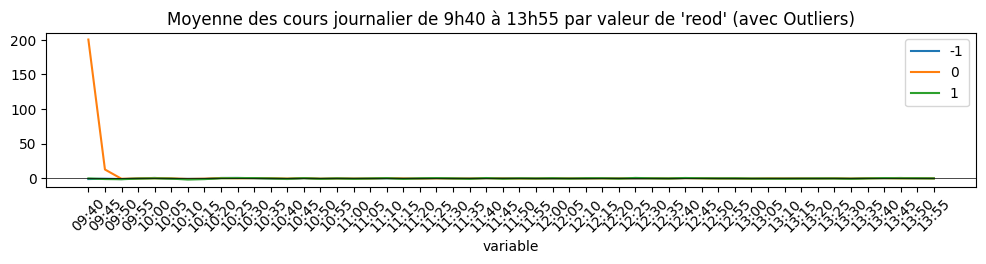

In [5]:
process_and_plot(df, '09:40', '13:55', 1, "mean", "Moyenne des cours journalier de 9h40 à 13h55 par valeur de 'reod' (avec Outliers)")

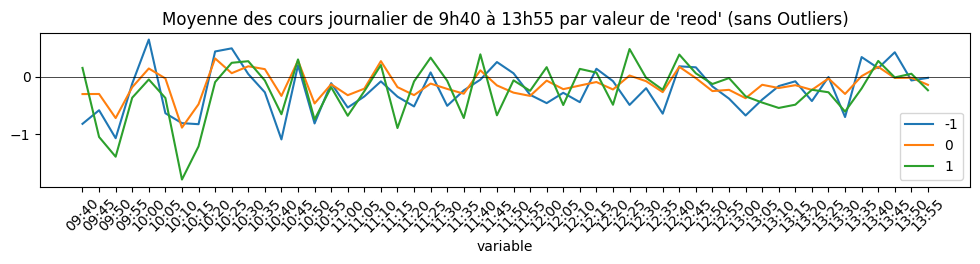

In [16]:
process_and_plot(df_outliers, '09:40', '13:55', 1, "mean", "Moyenne des cours journalier de 9h40 à 13h55 par valeur de 'reod' (sans Outliers)")

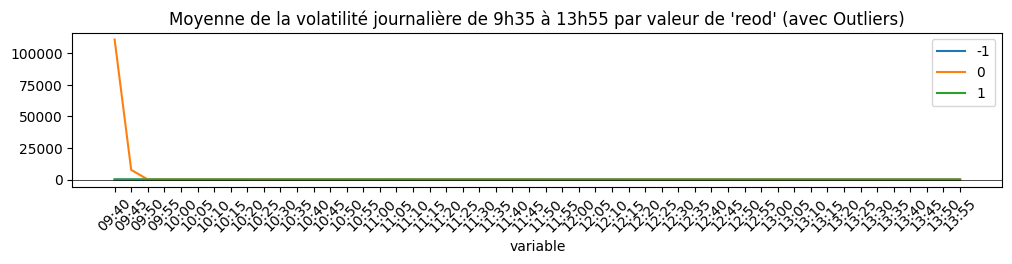

In [7]:
process_and_plot(df, '09:40', '13:55', 1, "std", "Moyenne de la volatilité journalière de 9h35 à 13h55 par valeur de 'reod' (avec Outliers)")

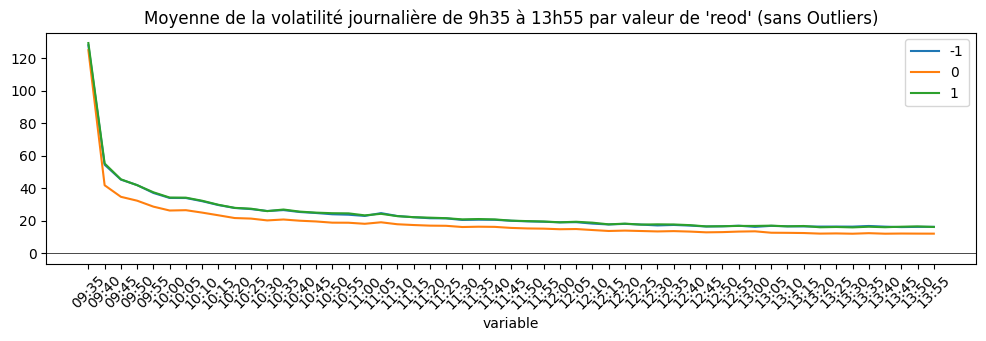

In [71]:
process_and_plot(df_outliers, '09:35', '13:55', 1, "std", "Moyenne de la volatilité journalière de 9h35 à 13h55 par valeur de 'reod' (sans Outliers)", (12,3))

In [67]:
def plot_volatility(df, titre, figsize_val=(12, 5)):
    df['volatility'] = df.iloc[:, 3:3+53].std(axis = 1) #Sum of the 52 first columns
    df['volatility_mean'] = df.groupby('day')['volatility'].transform('mean')
    df = df[['day','volatility_mean']].groupby('day').mean()

    if df.index[0] <= 1000000: 
        df.index = df.index - 1000000

    # Calculate the average volatility
    average_volatility = df['volatility_mean'].mean()

    #Plot Visu
    plt.figure(figsize=figsize_val)
    plt.plot(df)
    plt.axhline(average_volatility, color='red', linestyle='--', label='Average Volatility')
    plt.xlabel('Day')
    plt.ylabel('Volatility')
    plt.title(titre)
    plt.legend()
    plt.show()
    return

def plot_both_volatility(df, df2, func, titre, figsize_val=(12, 5), corrected = False):

    if func == "std":
        df['func'] = df.iloc[:, 3:3+53].std(axis = 1) #Sum of the 52 first columns
        df2['func'] = df2.iloc[:, 3:3+53].std(axis = 1) #Sum of the 52 first columns

    if func == "mean":
        df['func'] = df.iloc[:, 3:3+53].mean(axis = 1) #Sum of the 52 first columns
        df2['func'] = df2.iloc[:, 3:3+53].mean(axis = 1) #Sum of the 52 first columns

    df['func_mean'] = df.groupby('day')['func'].transform('mean')
    df = df[['day','func_mean']].groupby('day').mean()

    df2['func_mean'] = df2.groupby('day')['func'].transform('mean')
    df2 = df2[['day','func_mean']].groupby('day').mean()

    if df2.index[0] <= 1000000: 
        df2.index = df2.index - 1000000

    # Calculate the average volatility
    average_func_df = df['func_mean'].mean()
    average_func_df2 = df2['func_mean'].mean()

    if corrected == True:
        df['func_mean'] = df['func_mean'] / average_func_df
        df2['func_mean'] = df2['func_mean'] / average_func_df2
    #Plot Visu
    plt.figure(figsize=figsize_val)
    plt.plot(df, label = 'df_train')
    plt.plot(df2, label = 'df_test')
    plt.xlabel('Day')
    if func == "std" and corrected == False:
        plt.ylabel('Volatility')
        plt.axhline(average_func_df, color='red', linestyle='--', label='Average Volatility df_train')
        plt.axhline(average_func_df2, color='green', linestyle='--', label='Average Volatility df_test')
    if func == "mean" and corrected == False:
        plt.ylabel('Return')
        plt.axhline(average_func_df, color='red', linestyle='--', label='Average Return df_train')
        plt.axhline(average_func_df2, color='green', linestyle='--', label='Average Return df_test')
    if corrected == True:
        plt.axhline(1, color='green', linestyle='--')
    plt.title(titre)
    plt.legend()
    plt.show()
    return

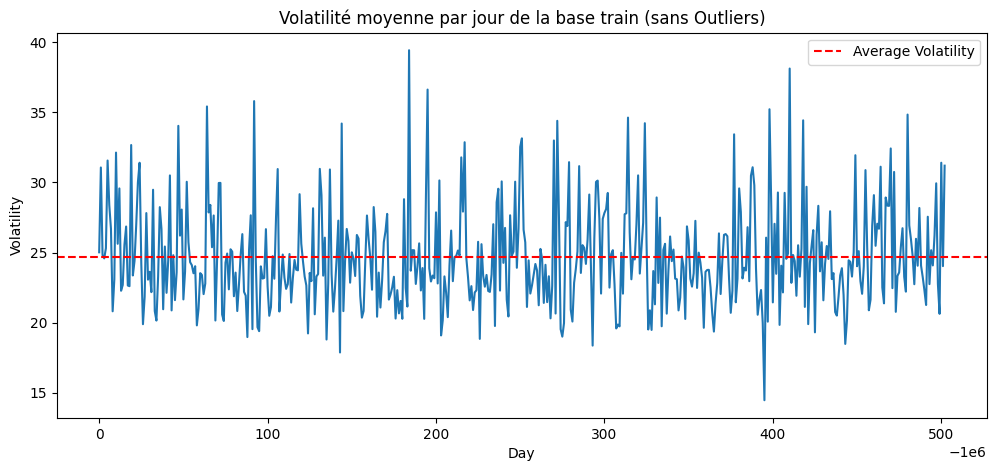

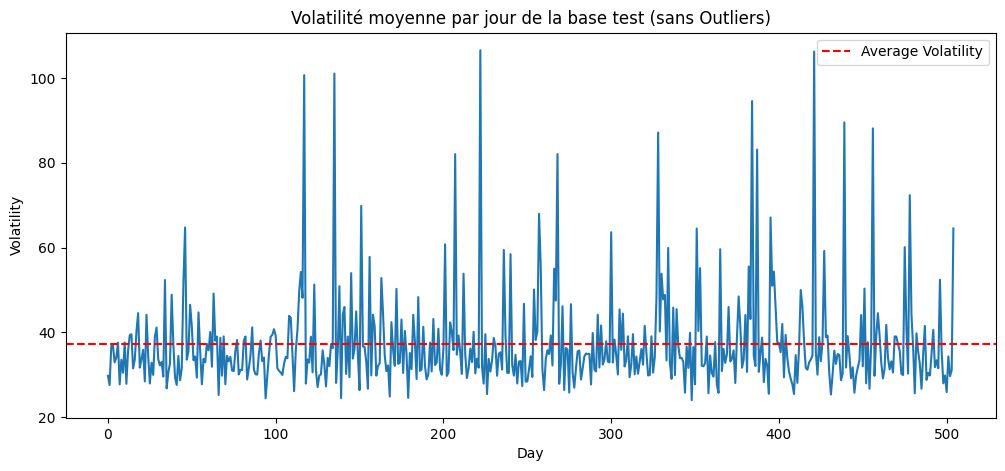

In [68]:
plot_volatility(df_outliers, "Volatilité moyenne par jour de la base train (sans Outliers)", figsize_val=(12, 5))
plot_volatility(df_outliers_test, "Volatilité moyenne par jour de la base test (sans Outliers)", figsize_val=(12, 5))

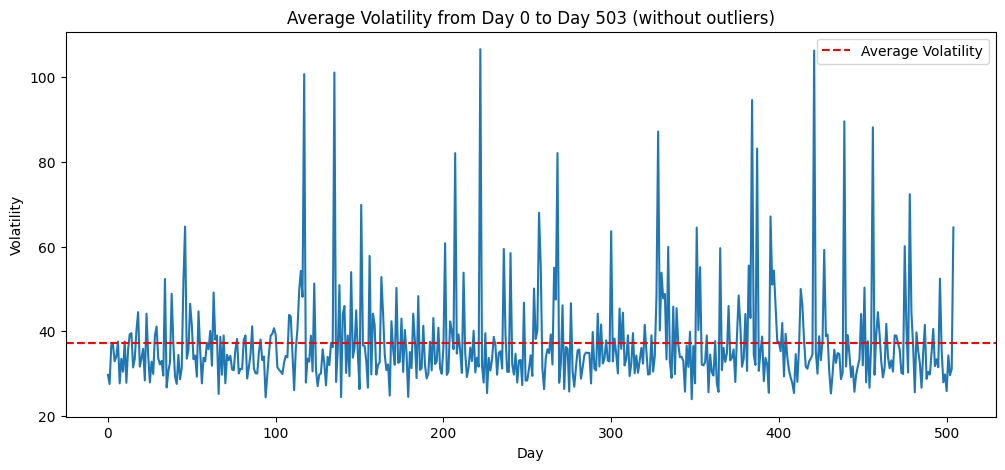

In [37]:
plot_volatility(df_outliers_test, "Average Volatility from Day 0 to Day 503 (without outliers)", figsize_val=(12, 5))

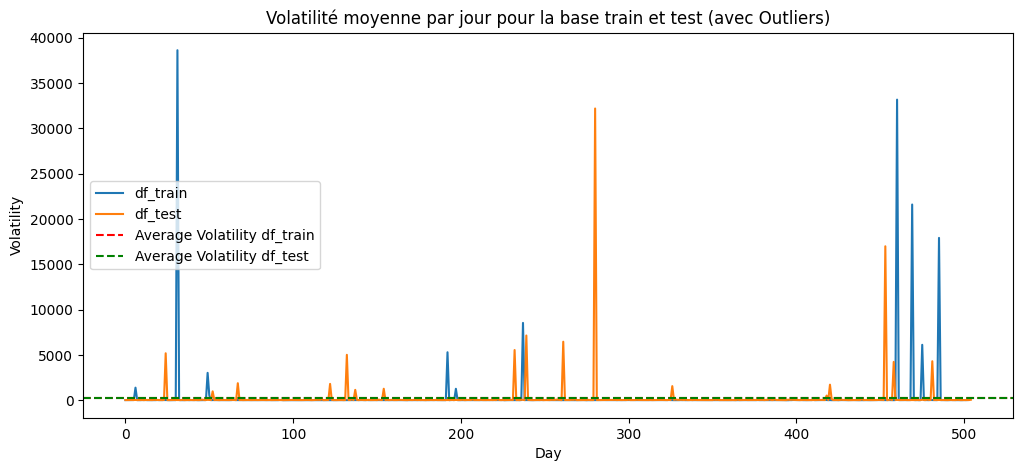

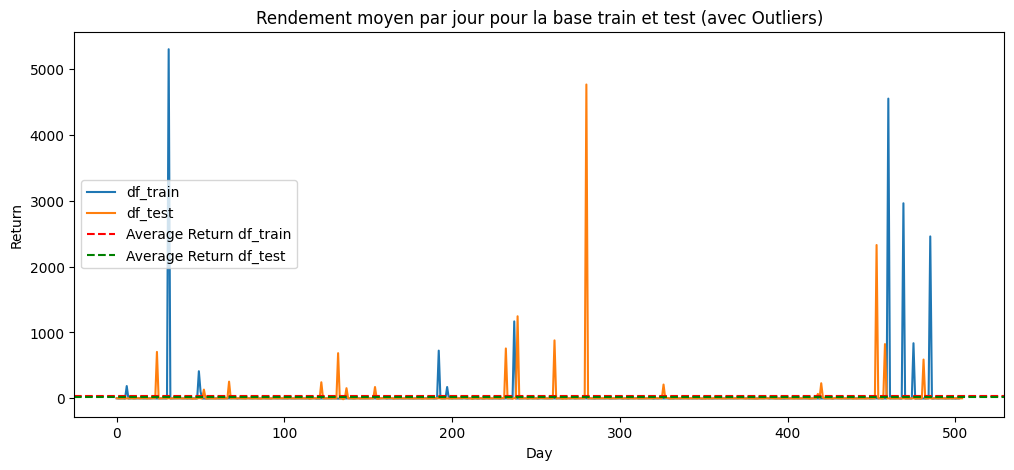

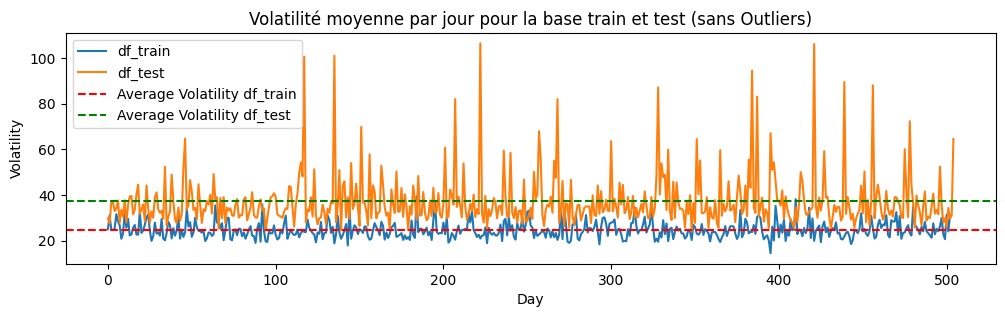

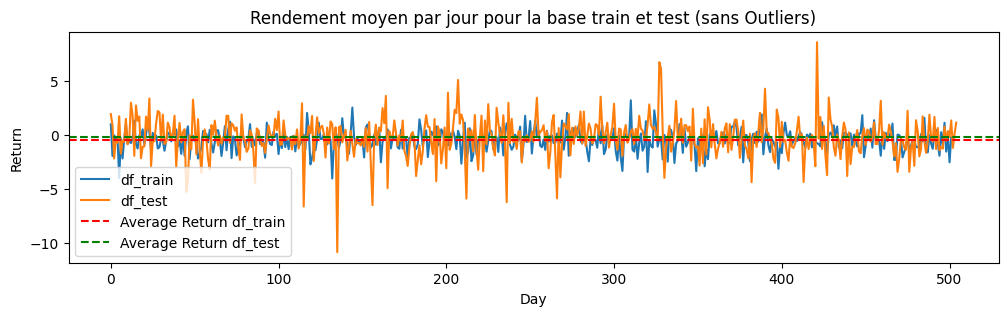

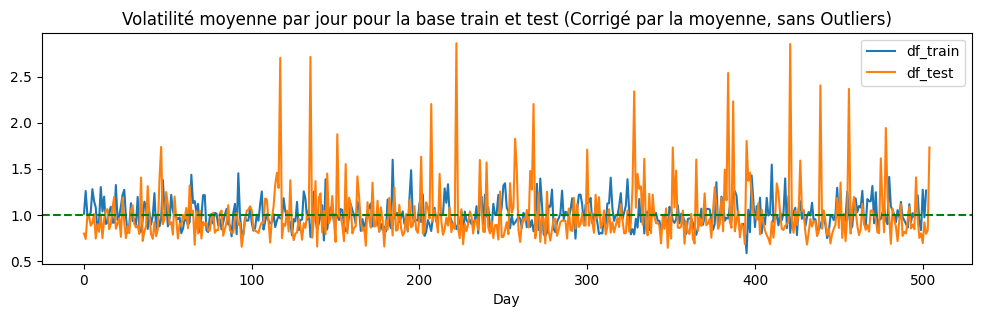

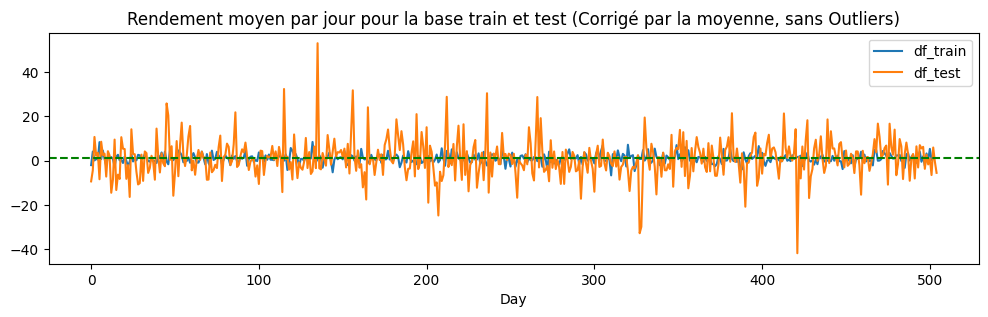

In [72]:
plot_both_volatility(df, df_test, "std", "Volatilité moyenne par jour pour la base train et test (avec Outliers)", figsize_val=(12, 5), corrected = False)
plot_both_volatility(df, df_test, "mean", "Rendement moyen par jour pour la base train et test (avec Outliers)", figsize_val=(12, 5), corrected = False)

plot_both_volatility(df_outliers, df_outliers_test, "std", "Volatilité moyenne par jour pour la base train et test (sans Outliers)", figsize_val=(12, 3), corrected = False)
plot_both_volatility(df_outliers, df_outliers_test, "mean", "Rendement moyen par jour pour la base train et test (sans Outliers)", figsize_val=(12, 3), corrected = False)

plot_both_volatility(df_outliers, df_outliers_test, "std", "Volatilité moyenne par jour pour la base train et test (Corrigé par la moyenne, sans Outliers)", figsize_val=(12, 3), corrected = True)
plot_both_volatility(df_outliers, df_outliers_test, "mean", "Rendement moyen par jour pour la base train et test (Corrigé par la moyenne, sans Outliers)", figsize_val=(12, 3), corrected = True)


Heatmap

In [81]:
# Create three new DataFrames
df_reod1 = df.copy()
df_reod1['reod'] = df_reod1['reod'].apply(lambda x: 1 if x == 1 else 0)

df_reod0 = df.copy()
df_reod0['reod'] = df_reod0['reod'].apply(lambda x: 1 if x == 0 else 0)

df_reod_minus1 = df.copy()
df_reod_minus1['reod'] = df_reod_minus1['reod'].apply(lambda x: 1 if x == -1 else 0)

# Group by 'equity' and calculate the sum of 'reod'
reod1_sum = df_reod1.groupby('equity')['reod'].sum().reset_index(name='reod1_sum')
reod0_sum = df_reod0.groupby('equity')['reod'].sum().reset_index(name='reod0_sum')
reod_minus1_sum = df_reod_minus1.groupby('equity')['reod'].sum().reset_index(name='reod_minus1_sum')

# Merge the three DataFrames
df_merged = pd.merge(reod1_sum, reod0_sum, on='equity')
df_merged = pd.merge(df_merged, reod_minus1_sum, on='equity')

df_merged['reod_sum'] = df_merged['reod1_sum'] + df_merged['reod0_sum'] + df_merged['reod_minus1_sum']

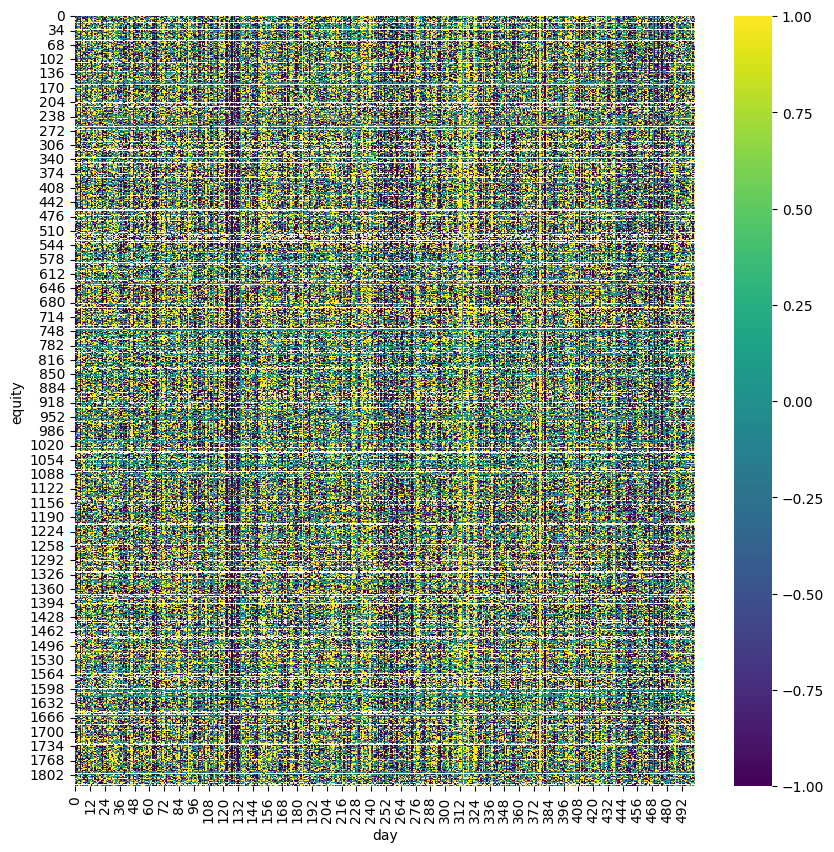

In [75]:
df_pivot = df.pivot(index = 'equity', columns = 'day', values = 'reod')

plt.figure(figsize=(10, 10))
sns.heatmap(df_pivot, cmap='viridis')
plt.show()

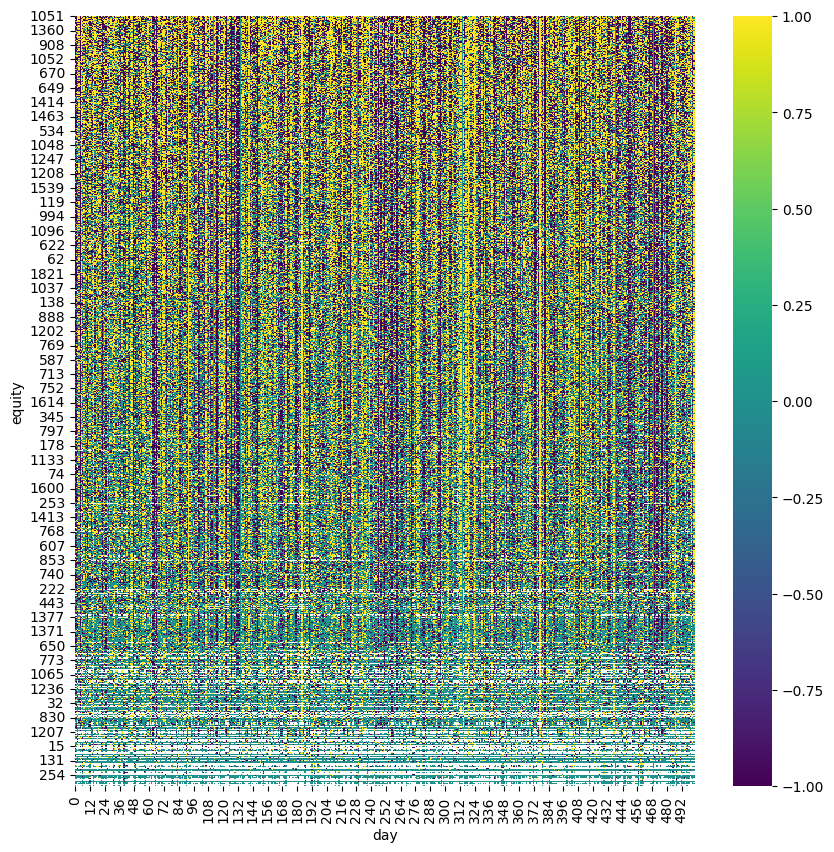

In [82]:
df_merged = df_merged.sort_values('reod1_sum', ascending=False)

# Pivot table
pivot_table = df.pivot(index='equity', columns='day', values='reod')

# Create a new index that matches the order of df_merged's index
new_index = df_merged['equity'].drop_duplicates()

# Reindex the pivoted DataFrame
pivot_table = pivot_table.reindex(new_index)

# Create heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(pivot_table, cmap='viridis')
plt.show()